In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class ProcessGBM:

    def __init__(self, mu, sigma):
        self._mu = mu
        self._sigma = sigma

    def Simulate(self, T=1, dt=0.001, S0=1.):
        n = round(T / dt)

        mu = self._mu
        sigma = self._sigma

        gaussian_increments = np.random.normal(size=n - 1)
        res = np.zeros(n)
        res[0] = S0
        S = S0
        sqrt_dt = dt ** 0.5
        for i in range(n - 1):
            S = S + S * mu * dt + sigma * \
                S * gaussian_increments[i] * sqrt_dt
            res[i + 1] = S

        return res

In [3]:
class ProcessCEV:

    def __init__(self, mu, sigma, gamma):
        self._mu = mu
        self._sigma = sigma
        self._gamma = gamma

    def Simulate(self, T=1, dt=0.001, S0=1.):
        n = round(T / dt)

        mu = self._mu
        sigma = self._sigma
        gamma = self._gamma

        gaussian_increments = np.random.normal(size=n - 1)
        res = np.zeros(n)
        res[0] = S0
        S = S0
        sqrt_dt = dt ** 0.5
        for i in range(n - 1):
            S = S + S * mu * dt + sigma * \
                (S ** gamma) * gaussian_increments[i] * sqrt_dt
            res[i + 1] = S

        return res

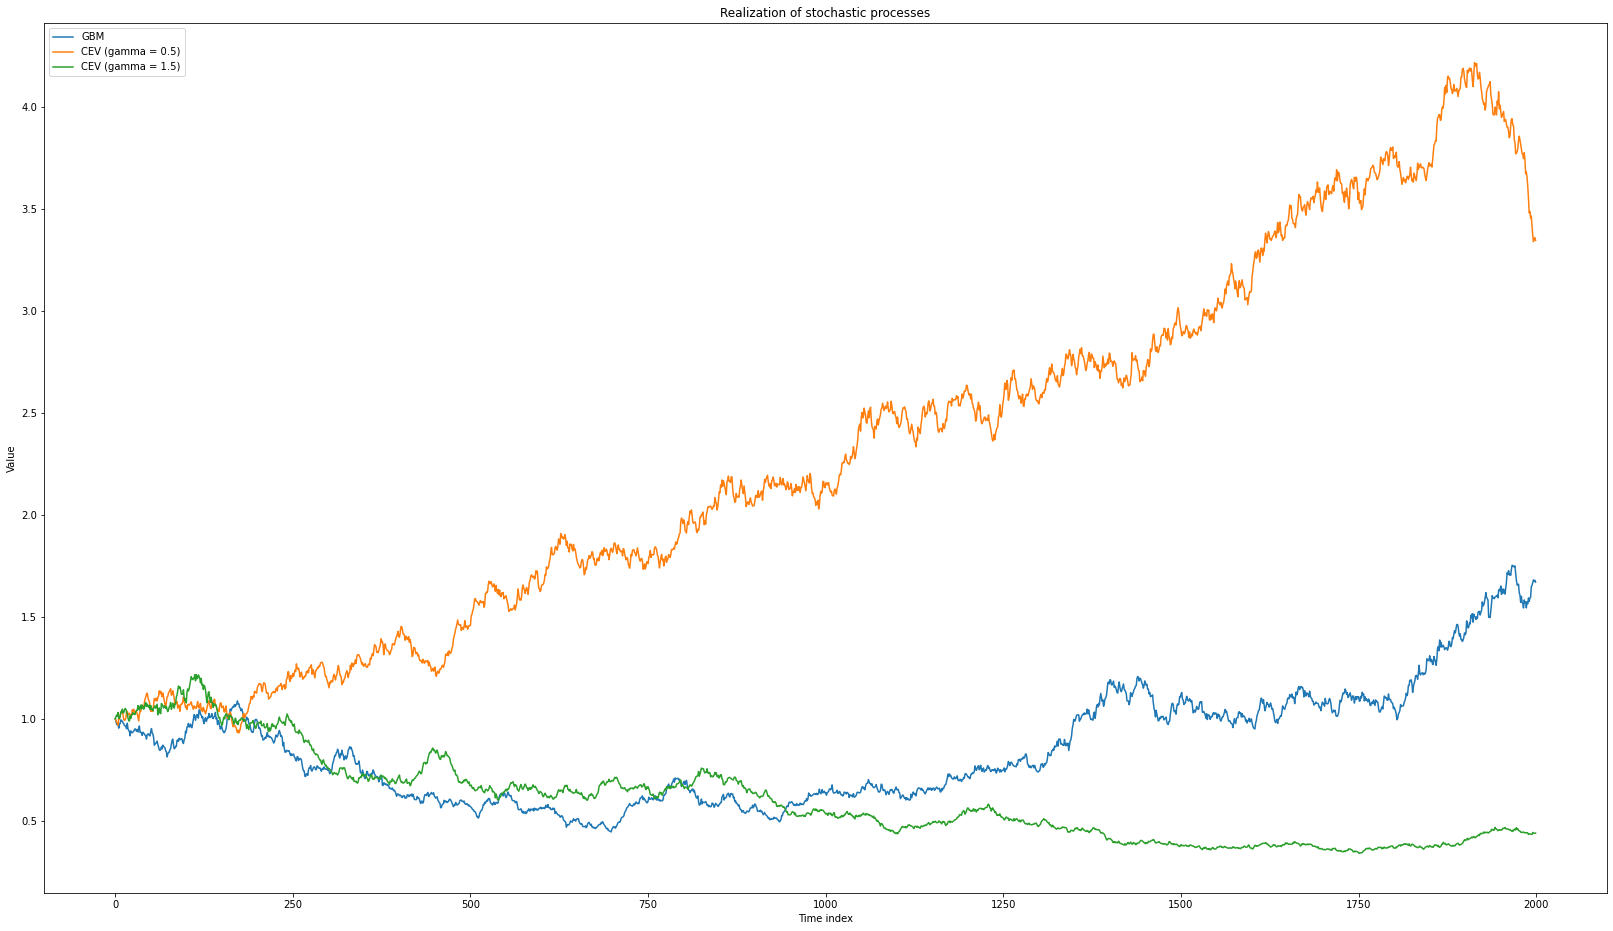

In [9]:
T = 20
dt = 0.01
fig = plt.figure(figsize=(28,16))
plt.plot(ProcessGBM(0.05, 0.15).Simulate(T, dt), label="GBM")
plt.plot(ProcessCEV(0.05, 0.15, 0.5).Simulate(
    T, dt), label="CEV (gamma = 0.5)")
plt.plot(ProcessCEV(0.05, 0.15, 1.5).Simulate(
    T, dt), label="CEV (gamma = 1.5)")

plt.xlabel('Time index')
plt.ylabel('Value')

plt.title("Realization of stochastic processes")

plt.legend()

plt.show()

In [7]:
class EstimatorCEV:

    def __init__(self, dt):
        self._dt = dt
        self._alpha0 = -5

    def Estimate(self, trajectory):
        sigma, gamma = self._evaluate_sigma_gamma(trajectory, self._alpha0)
        if sigma == None:
            return None, None, None
        else:
            mu = self._estimate_mu(trajectory)
            return (mu, sigma, gamma)

    def _log_increments(self, trajectory):
        return np.diff(trajectory) / trajectory[:-1]

    def _estimate_mu(self, trajectory):
        return np.mean(self._log_increments(trajectory)) / self._dt

    def _log_increments_alpha(self, trajectory, alpha):
        mod_increments = self._log_increments(trajectory ** (1 + alpha))
        return mod_increments / (1 + alpha)

    def _evaluate_Vt(self, trajectory, alpha):
        lhs = self._log_increments_alpha(trajectory, alpha)
        rhs = self._log_increments(trajectory)
        center = 2 * (lhs - rhs) / (alpha * self._dt)
        return center

    def _evaluate_sigma_gamma(self, trajectory, alpha):
        if np.any(trajectory <= 0):
            return None, None

        Vts = self._evaluate_Vt(trajectory, alpha)
        if np.any(Vts <= 0):
            return None, None
        logVts = np.log(Vts)

        Sts = trajectory[:-1]  # removes the last term as in eq. (5)
        if np.any(Sts <= 0):
            return None, None
        logSts = np.log(Sts)

        ones = np.ones(Sts.shape[0])
        A = np.column_stack((ones, logSts))

        res = np.linalg.lstsq(A, logVts, rcond=None)[0]
        return (2 * np.exp(res[0] / 2), 0.5 * (res[1] + 2))

In [8]:
def test(true_mu, true_sigma, true_gamma):
        dt = 0.001
        T = 10

        sample_mu = []
        sample_sigma = []
        sample_gamma = []

        for i in range(100):
            mu_est, sigma_est, gamma_est = EstimatorCEV(dt=dt).Estimate(ProcessCEV(
                true_mu, true_sigma, true_gamma).Simulate(T, dt=dt))

            if mu_est != None:
                sample_mu = [mu_est] + sample_mu
                sample_sigma = [sigma_est] + sample_sigma
                sample_gamma = [gamma_est ] + sample_gamma

        print("mu : " + str(true_mu) + " \t| est : " + str(np.mean(sample_mu)) + " \t| std : " + str(np.std(sample_mu)))
        print("sigma : " + str(true_sigma) + " \t| est : " + str(np.mean(sample_sigma)) + " \t| std : " + str(np.std(sample_sigma)))
        print("gamma : " + str(true_gamma) + " \t| est : " + str(np.mean(sample_gamma)) + " \t| std : " + str(np.std(sample_gamma)))
        print(10*"-")


test(0.,0.5,0.8)
test(0.2,0.5,0.8)
test(0.2,0.5,1.2)
test(0.,0.3,0.2)
test(0.,0.5,2)

/var/folders/kb/1kf8hw_j5z585qrzxggc650r0000gq/T/ipykernel_35891/2391581425.py:22: RuntimeWarning: invalid value encountered in double_scalars
  (S ** gamma) * gaussian_increments[i] * sqrt_dt


mu : 0.0 	| est : 0.02131459315379176 	| std : 0.14006567555711313
sigma : 0.5 	| est : 0.5296558450779991 	| std : 0.010527110625102169
gamma : 0.8 	| est : 0.7974101777213406 	| std : 0.019974796917202328
----------
mu : 0.2 	| est : 0.20519838747775038 	| std : 0.14891262760979493
sigma : 0.5 	| est : 0.5308379860548679 	| std : 0.010402955162261675
gamma : 0.8 	| est : 0.8007242515432437 	| std : 0.020181590563461742
----------
mu : 0.2 	| est : 0.21893377187597468 	| std : 0.18114304433066805
sigma : 0.5 	| est : 0.5320370225761575 	| std : 0.008864924432860303
gamma : 1.2 	| est : 1.1992606627417368 	| std : 0.022004441215759396
----------
mu : 0.0 	| est : 0.09366989229043553 	| std : 0.0921891084796795
sigma : 0.3 	| est : 0.3179849065046527 	| std : 0.0055492328174427475
gamma : 0.2 	| est : 0.1961746027098491 	| std : 0.03616754581001588
----------


/var/folders/kb/1kf8hw_j5z585qrzxggc650r0000gq/T/ipykernel_35891/2391581425.py:22: RuntimeWarning: overflow encountered in double_scalars
  (S ** gamma) * gaussian_increments[i] * sqrt_dt
/var/folders/kb/1kf8hw_j5z585qrzxggc650r0000gq/T/ipykernel_35891/2391581425.py:21: RuntimeWarning: invalid value encountered in double_scalars
  S = S + S * mu * dt + sigma * \


mu : 0.0 	| est : -0.019350578000382455 	| std : 0.0908162834520116
sigma : 0.5 	| est : 0.529978196980562 	| std : 0.01235749745722193
gamma : 2 	| est : 2.0025203648848557 	| std : 0.03360640020216814
----------
